# Predicting Option Prices

Directory <br>
1.0 [The Black Scholes Model](#1)
- 1.1 [The Setup](#2)
- 1.2 [Calculating Implied Volatility](#3)
- 1.3 [Predicting and Evaluating](#4)
- 1.4 [Further Analyais](#5)

2.0 [Monte Carlo Methods](#6)
- 2.1 [Implementation](#7)
- 2.2 [Further Analysis](#8)

In [1]:
import numpy as np
import pandas as pd
from math import log, exp, sqrt
from scipy.stats import norm
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("icefire")

## The Black Scholes Model <a name="1"></a>

The price of a call option is given by: <br>
>$C_0 = S_0 N(d_1) - Ee^{-rT}N(d_2)$ <br>

where... <br>
$S_0$ = current stock price, and $E$ = exercise price <br>
$N(d_i) = P($standard normal random variable $\leq d_i)$  i.e. normal CDF <br>
$d_1 = \frac{ln(S_0/E) + (r + \sigma^2 / 2)T}{\sigma \sqrt{T}}$, 
$d_2 = d_1 - \sigma \sqrt{T}$ <br>
$\sigma$ = std. of the stock's annual return (continuously compounded) <br>
$r$ = annual risk free rate (continuously compounded)<br>
$T$ = years to maturity <br>

This is the solution to the Black Scholes partial differential equation: <br>
>$dS_t = rS_tdt + \sigma S_t d Z_t$ <br>

where $Z(t)$ = Brownian Motion

**Key Assumptions**:
1. The option is European - it cannot be exercised before expiration
2. The underlying asset does not pay a dividend
3. Markets are efficient and no arbitrage opportunities exist
4. The returns on the underlying asset are normally distributed
5. The risk-free rate and volatility are constant

## Setup <a name="2"></a>

In [2]:
N = norm.cdf
n = norm.pdf

def call(S, E, r, sigma, T): 
    d1 = (log(S / E) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    call = S * N(d1) - E * exp(-r*T) * N(d2)
    return round(call, 8)

def put(S, E, r, sigma, T):
    d1 = (log(S / E) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    put = E * exp(-r*T) * (1 - N(d2)) - S * (1 - N(d1))
    return round(put, 8)

In [3]:
# Combine the above with an additional parameter
def price(S, E, r, sigma, T, option):
    d1 = (log(S / E) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    if option == 'c':
        price = S * N(d1) - E * exp(-r*T) * N(d2)
    else:
        price = E * exp(-r*T) * (1 - N(d2)) - S * (1 - N(d1))
    return round(price, 8)

In [4]:
# Test the function
S = 36400
E = 30000
r = 0.05
sigma = 0.53
T = 1
price(S, E, r, sigma, T, 'c')

11399.73195256

In [5]:
# load data (source: https://finance.yahoo.com/quote/TSLA/history?p=TSLA)
data = pd.read_csv('TSLA.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-19,184.699997,188.955994,180.203995,183.483994,183.483994,127115000
1,2020-02-20,182.389999,182.399994,171.988007,179.882004,179.882004,88174500
2,2020-02-21,181.395996,182.612000,176.089996,180.199997,180.199997,71574000
3,2020-02-24,167.800003,172.699997,164.440002,166.757996,166.757996,75961000
4,2020-02-25,169.800003,171.320007,157.399994,159.981995,159.981995,86452500
...,...,...,...,...,...,...,...
249,2021-02-12,801.260010,817.330017,785.330017,816.119995,816.119995,23701700
250,2021-02-16,818.000000,821.000000,792.440002,796.219971,796.219971,19686700
251,2021-02-17,779.090027,799.840027,762.010010,798.150024,798.150024,25996500
252,2021-02-18,780.900024,794.690002,776.270020,787.380005,787.380005,17897000


In [6]:
# check for NAs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       254 non-null    object 
 1   Open       254 non-null    float64
 2   High       254 non-null    float64
 3   Low        254 non-null    float64
 4   Close      254 non-null    float64
 5   Adj Close  254 non-null    float64
 6   Volume     254 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


Disclaimer: Needless to say, Tesla's options are not settled European style. Let's pretend they are for the time being though... <br>
I was unable to find data on European options, and when I eventually found some, I was unable to find the money or the willingness to pay for it.

## Calculating Implied Volatility <a name="3"></a>

**Method 1**: Newton's method for root approximation
- iterate over values of $\sigma$ 
- calculate slope of the tangent line evaluated at each iteration point 
- repeat until the approximation is close enough to the true root  

In [7]:
# Helper function: vega, an option greek
# Vega measures price sensitivity to changes in iv (partial derivative of C w.r.t. sigma)
def vega(S, E, r, sigma, T):
    d1 = (log(S / E) + (r + sigma ** 2 / 2) * T) / (sigma * sqrt(T))
    deriv = S * n(d1) * np.sqrt(T)
    return deriv 

In [8]:
# Implement Newton's method
def iv(targetVal, S, E, r, T):
    sigma = 0.5      # starting test value
    EPSILON = 1.0e-5 # precision tolerance
    MAX_ITER = 200    
    
    for i in range(0, MAX_ITER):
        price = call(S, E, r, sigma, T)
        v = vega(S, E, r, sigma, T)    # f'(x)
        fVal = price - targetVal       # f(x)
        if (abs(fVal) < EPSILON):
            return sigma # satisfactory estimate found
        sigma = sigma - fVal/v      # x1 = x0 - f(x0) / f'(x0)
    return sigma         # satisfactory estimate not found within MAX_ITER

In [9]:
# Test the function
targetVal = call(S, E, r, sigma, T)
implied_vol = iv(targetVal, S, E, r, T)
implied_vol

0.5300000000002799

>With large datasets, method 1 can be computationally expensive. <br>
Try method 2: calculating stock returns and taking standard deviation directly

In [10]:
# Calculate returns
data = data.assign(Return = (data.Close - data.Close.shift(1)) / data.Close.shift(1))
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Return
count,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02,253.000000
mean,380.116466,389.655890,369.957252,380.861637,380.861637,6.467769e+07,0.007157
std,232.561731,236.803456,228.210010,233.493858,233.493858,3.368546e+07,0.053106
min,74.940002,80.972000,70.101997,72.244003,72.244003,1.515770e+07,-0.210628
25%,165.891998,167.414501,161.790005,163.924504,163.924504,3.878098e+07,-0.020635
50%,356.300003,369.085999,338.038010,366.703995,366.703995,5.977230e+07,0.003716
75%,474.284996,499.105011,446.387504,483.742508,483.742508,8.484608e+07,0.034152
max,891.380005,900.400024,871.599976,883.090027,883.090027,2.221262e+08,0.183877


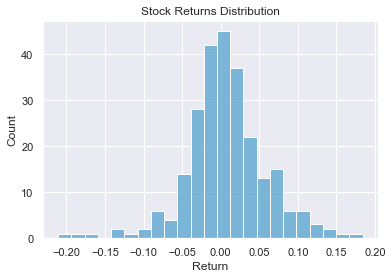

In [11]:
# Plot distribution of returns to gauge accuracy of the Normal returns assumption
sns.histplot(data.Return)
plt.title("Stock Returns Distribution")
plt.show()

In [12]:
# Calculate iv
tradingDays = 252 # source: https://en.wikipedia.org/wiki/Trading_day#2021
iv = np.sqrt(tradingDays) * data['Return'].std()
iv

0.8430304241811181

## Predicting and Evaluating <a name="4"></a>

In [13]:
# Load data for calls with exercise date = Feb 26, 2021
# source: ('https://finance.yahoo.com/quote/TSLA/options?date=1614297600&p=TSLA')[0]
calls = pd.read_csv('Calls.csv')
calls.describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,917.764550,62.367354,61.059683,62.057566,-3.236243,711.338624,504.608466
std,314.265115,122.323555,119.737958,120.766869,4.813903,1893.182520,903.999562
min,200.000000,0.010000,0.000000,0.020000,-22.730000,1.000000,1.000000
25%,747.500000,0.100000,0.050000,0.150000,-6.550000,12.000000,85.000000
50%,865.000000,1.560000,1.450000,1.630000,-1.020000,128.000000,211.000000
75%,1110.000000,40.770000,41.550000,43.300000,-0.050000,518.000000,510.000000
max,1700.000000,581.900000,579.850000,582.850000,10.150000,15141.000000,6603.000000


In [14]:
# Predict prices with BS function!
days = 7 # time until maturity
spot = 781.3 # source: https://finance.yahoo.com/quote/TSLA?p=TSLA&.tsrc=fin-srch
rf = 1.345 # source: https://finance.yahoo.com/quote/%5ETNX?p=%5ETNX
calls['Implied Volatility'] = calls['Implied Volatility'].str.rstrip('%').astype('float') / 100.0
prediction = []
for i in range(0, len(calls)):
    price = call(spot, calls['Strike'][i], rf, calls['Implied Volatility'][i], days/365)
    prediction.append(price)

In [15]:
calls.describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,Implied Volatility
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,917.764550,62.367354,61.059683,62.057566,-3.236243,711.338624,504.608466,0.963260
std,314.265115,122.323555,119.737958,120.766869,4.813903,1893.182520,903.999562,0.504783
min,200.000000,0.010000,0.000000,0.020000,-22.730000,1.000000,1.000000,0.494000
25%,747.500000,0.100000,0.050000,0.150000,-6.550000,12.000000,85.000000,0.535300
50%,865.000000,1.560000,1.450000,1.630000,-1.020000,128.000000,211.000000,0.758800
75%,1110.000000,40.770000,41.550000,43.300000,-0.050000,518.000000,510.000000,1.339400
max,1700.000000,581.900000,579.850000,582.850000,10.150000,15141.000000,6603.000000,3.453100


In [16]:
# Append predictions column
calls = calls.assign(Black_Scholes = prediction)
calls.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Black_Scholes
0,TSLA210226C00200000,2021-02-17 9:55AM EST,200.0,581.90,579.85,582.85,-3.60,-0.61%,20,1,3.4531,586.490399
1,TSLA210226C00250000,2021-02-19 12:51PM EST,250.0,530.60,529.85,532.85,3.00,0.57%,3,9,2.9063,537.761175
2,TSLA210226C00350000,2021-02-17 1:23PM EST,350.0,433.92,429.90,432.85,0.00,-,3,14,2.1523,440.336386
3,TSLA210226C00360000,2021-02-10 2:36PM EST,360.0,453.00,419.90,422.95,0.00,-,5,7,2.1836,430.664295
4,TSLA210226C00370000,2021-02-12 9:35AM EST,370.0,417.80,409.90,412.90,-7.25,-1.71%,2,14,2.0664,420.880462


In [17]:
# Benchmark against ask price to see how far off we are from option traders' expectations
BS_Dif = calls['Black_Scholes'] - calls['Ask']
BS_Dif.describe()

count    189.000000
mean       5.610001
std        5.746383
min        0.044737
25%        0.206122
50%        2.804571
75%       11.173063
max       15.712723
dtype: float64

Looking at these numbers, the accuracy seems very promising. However, it is important to consider the magnitude of our predictions. <br>
Some predictions (those with high strike prices) have an ask price of only a few cents. 
If we priced a call with ask = $0.02 at $0.04, the % difference will be 200%. <br>

From the summary statistics, 50% of the calls have an ask price of < $1.63. An average difference of $5.61 no longer looks promising. <br>
While the model gave us accurate results for more expensive call options, we need to look at the % difference for inexpensive call options as well.

The data is sorted by strike price in ascending order. Let's take a look at the last 5.

In [18]:
calls.tail()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Black_Scholes
184,TSLA210226C01600000,2021-02-19 3:36PM EST,1600.0,0.02,0.02,0.03,0.00,-,15,100,1.6719,0.102558
185,TSLA210226C01625000,2021-02-18 2:17PM EST,1625.0,0.03,0.01,0.05,0.00,-,21,113,1.7266,0.118409
186,TSLA210226C01650000,2021-02-19 1:40PM EST,1650.0,0.02,0.01,0.02,-0.02,-50.00%,10,205,1.6719,0.064737
187,TSLA210226C01675000,2021-02-19 11:37AM EST,1675.0,0.02,0.01,0.02,0.00,-,8,211,1.7031,0.064839
188,TSLA210226C01700000,2021-02-19 3:39PM EST,1700.0,0.02,0.01,0.02,0.00,-,1146,4751,1.7344,0.065234


Indeed, our predictions were 2-3 times higher than the ask price.

In [19]:
# Examine the % difference instead
calls['BS_Dif_Pct'] = BS_Dif / calls['Black_Scholes'] * 100
calls['BS_Dif_Pct'].describe()

count    189.000000
mean      44.309673
std       23.518224
min        0.620709
25%       25.786105
50%       53.032522
75%       64.528658
max       71.808395
Name: BS_Dif_Pct, dtype: float64

The % difference is high at 44.3%. What percent of this is coming from inexpensive calls? <br>
We can visualize this by plotting our predictions against the ask price (our accuracy metric).

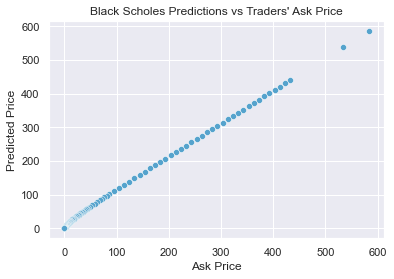

In [20]:
sns.scatterplot(data = calls, x = 'Ask', y = 'Black_Scholes')
plt.xlabel("Ask Price")
plt.ylabel("Predicted Price")
plt.title("Black Scholes Predictions vs Traders' Ask Price")
plt.show()

Almost perfectly linear. Let's add f(x) = y to the plot.

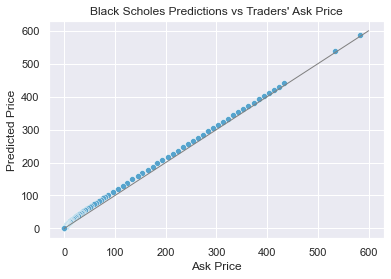

In [21]:
sns.scatterplot(data = calls, x = "Ask", y = "Black_Scholes")
plt.plot([0, 600], [0, 600], color = 'grey', linewidth = 1)
plt.xlabel("Ask Price")
plt.ylabel("Predicted Price")
plt.title("Black Scholes Predictions vs Traders' Ask Price")
plt.show()

Roughly speaking, predicted price = ask price (y = x) the majority of the time. <br>
This confirms our suspicions: the inaccuracy is indeed coming from the many inexpensive calls that were overpriced by our model.

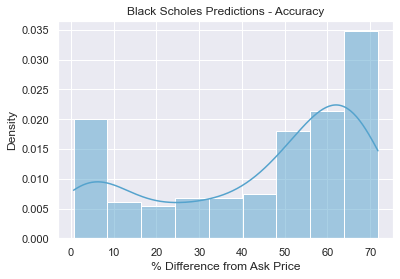

In [22]:
# Density histogram to see 
sns.histplot(calls['BS_Dif_Pct'], stat = "density", kde = True)
plt.xlabel("% Difference from Ask Price")
plt.title("Black Scholes Predictions - Accuracy")
plt.show()

The Black Scholes Model did not produce highly accurate predictions when benchmarked against the ask price. Only 25% achieved 75% accuracy. <br>
This was expected, however, since the market has been hit by COVID, and also the model assumes many unrealistic settings. 

1. In these uncertain times, the model assumes ***constant*** volatility and risk free rate when they are more dynamic than ever. 


2. The model also assumes that the asset's returns are ***normally*** distributed - this is not always the case. <br> 
Without knowing the shape of the distribution, how heavy the tails are, getting an accurate prediction is a difficult feat. <br>
The distribution is roughly normal in this case, so the assumption isn't too far off. <br>
(Note: Black Scholes underestimates ***tail risk***, which translates to the probability of Black Swan events.)<br>


3. Additionally, the model is meant to be used on ***European*** options only. <br>With that said, this flawed implementation of the Black Scholes Model turned out to be more accurate than expected, <br>considering the current market conditions and the model's limitations.

## Further Analysis <a name="5"></a>

Which calls were predicted most accurately? Which were the least accurate? <br>
Is the accuracy of our predictions correlated with any other factors? Let's find out.

In [23]:
# take absolute value of the difference
calls = calls.assign(abs_BS_Dif_Pct = abs(calls['BS_Dif_Pct'])) 
# sort by the absolute value column
BS = calls.sort_values(by = 'abs_BS_Dif_Pct').drop(['Contract Name', 'Last Trade Date'], 1)
# get summary stats on top 20 most accurate predictions
BS.head(20).describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,Implied Volatility,Black_Scholes,BS_Dif_Pct,abs_BS_Dif_Pct
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000
mean,414.000000,373.605000,365.945000,369.050000,-2.148000,10.800000,14.8500,1.903120,378.108695,2.586919,2.586919
std,82.423809,82.816585,82.364175,82.280186,6.752414,12.821035,16.6742,0.502116,80.211700,0.975694,0.975694
min,200.000000,254.100000,260.100000,263.350000,-14.940000,2.000000,1.0000,1.385700,275.042281,0.620709,0.620709
25%,377.500000,318.147500,307.500000,310.650000,-6.725000,3.000000,7.0000,1.590350,321.188733,1.975836,1.975836
50%,425.000000,355.035000,354.925000,358.000000,0.000000,5.500000,10.5000,1.785150,367.353801,2.547156,2.547156
75%,472.500000,413.225000,402.400000,405.400000,1.412500,11.500000,14.0000,2.013675,413.569512,3.282190,3.282190
max,520.000000,581.900000,579.850000,582.850000,10.150000,53.000000,78.0000,3.453100,586.490399,4.251085,4.251085


In [24]:
# compare to the 20 least accurate predictions
BS.tail(20).describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,Implied Volatility,Black_Scholes,BS_Dif_Pct,abs_BS_Dif_Pct
count,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1310.250000,0.14450,0.128000,0.151000,-0.237000,1178.050000,1284.450000,1.225130,0.493795,69.732629,69.732629
std,295.187162,0.18506,0.177189,0.189706,0.353525,2972.650819,2022.805282,0.435764,0.614162,1.227285,1.227285
min,900.000000,0.02000,0.010000,0.020000,-1.190000,3.000000,29.000000,0.577200,0.064737,67.483100,67.483100
25%,978.750000,0.02000,0.020000,0.030000,-0.430000,9.500000,197.000000,0.735725,0.100130,69.142321,69.142321
50%,1425.000000,0.03000,0.020000,0.035000,-0.025000,149.500000,414.500000,1.433600,0.113539,69.886711,69.886711
75%,1556.250000,0.23750,0.205000,0.250000,0.000000,758.500000,1298.750000,1.583975,0.833985,70.462909,70.462909
max,1700.000000,0.67000,0.650000,0.680000,0.000000,13147.000000,6603.000000,1.734400,2.186011,71.808395,71.808395


Observations from comparing the above tables:
- average last price, bid, & ask: **~$300** for most accurate, vs **~$1.5** for least accurate 
- average volume: **16** for most accurate, vs **2008** for least accurate 
- the **least** accurate predictions came from a **narrow range**: strike price $\in [845, 950]$
- the **std** of last price, bid, ask, is much **smaller** for the least accurate predictions 

Let's explore this further with some scatter plots. 

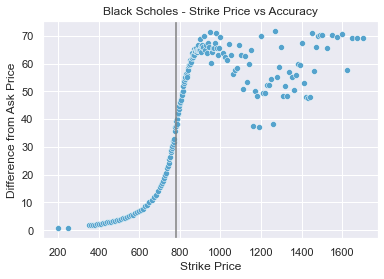

In [25]:
# Regression analysis: how does strike price affect our chosen accuracy metric? (dif between predictions and ask price)
sns.scatterplot(data = calls, x = "Strike", y = "abs_BS_Dif_Pct")
plt.xlabel('Strike Price')
plt.ylabel('Difference from Ask Price')
plt.title('Black Scholes - Strike Price vs Accuracy')
plt.axvline(x = spot, color = 'grey') # mark the spot price with a grey line
plt.show()

ITM calls (data points to the left of the grey bar) are more accurate! <br>
OTM calls are less accurate, and this is consistent with our earlier findings - inexpensive calls were not predicted accurately. <br>
High strike price $\to$ zero intrinsic value $\to$ OTM $\to$ inexpensive $\to$ low accuracy

In [26]:
# Let's look at the accuracy for in-the-money calls only
ITM = calls[calls['Strike'] < spot]
ITM.BS_Dif_Pct.describe()

count    61.000000
mean     13.392678
std      11.511579
min       0.620709
25%       3.417192
50%       8.546192
75%      23.106595
max      37.546107
Name: BS_Dif_Pct, dtype: float64

The predictions for ITM calls are indeed much closer to the ask price. On average, they were only off by 12% from the ask price.

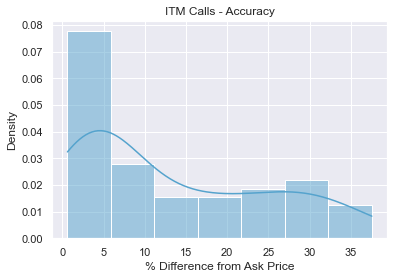

In [27]:
sns.histplot(ITM['BS_Dif_Pct'], stat = "density", kde = True)
plt.xlabel("% Difference from Ask Price")
plt.title("ITM Calls - Accuracy")
plt.show()

In [28]:
# Look at out-of-the-money calls
OTM = calls[calls['Strike'] > spot]
OTM.BS_Dif_Pct.describe()

count    128.000000
mean      59.043554
std        8.846210
min       37.191269
25%       52.823461
50%       61.290991
75%       65.730252
max       71.808395
Name: BS_Dif_Pct, dtype: float64

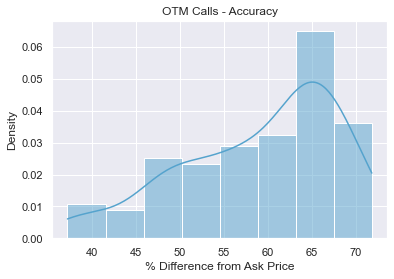

In [29]:
sns.histplot(OTM['BS_Dif_Pct'], stat = "density", kde = True)
plt.xlabel("% Difference from Ask Price")
plt.title("OTM Calls - Accuracy")
plt.show()

This is consistent with what we know - the BS model cannot be relied on to price options that are far out of the money. <br>

Let's dig deeper. Other than the strike price, what other factors are correlated with accuracy?

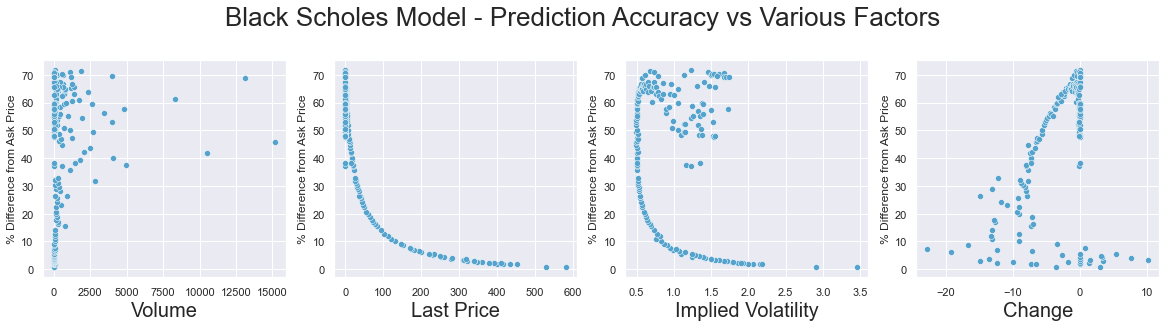

In [30]:
# Test to see which factors are correlated with our chosen accuracy metric
def subScatter(y, method):
    size = 20
    factors = ['Volume', 'Last Price', 'Implied Volatility', 'Change']    
    f, ax = plt.subplots(1, 4, figsize=(20, 4))
    for i in range(0, 4):
        factor = factors[i]
        sns.scatterplot(data = calls, x = factor, y = y, ax = ax[i])
        ax[i].set_xlabel(factor, fontsize = size, y = -0.2)
        ax[i].set_ylabel("% Difference from Ask Price")        
        
    plt.figtext(0.5, 1, method + ' - Prediction Accuracy vs Various Factors', fontsize = 26, ha = 'center')
    plt.show()

subScatter(calls.abs_BS_Dif_Pct, 'Black Scholes Model')

It appears that
- accuracy and volume are generally not correlated
- higher last transaction prices guarantees higher accuracy and vice versa <br>(consistent with earlier findings, since ask price and last price are almost perfectly correlated)
- higher iv sometimes leads to higher accuracy
- options with changes of -10% to 0% tend to be less accurate

Let's try a different method - one that isn't limited to vanilla European options and doesn't assume Normal returns in the underlying. 

No more unrealistic assumptions!

## Monte Carlo Method<a name="6"></a>

In [31]:
# Test the method on the first call option in our data set
calls.loc[0]

Contract Name           TSLA210226C00200000
Last Trade Date       2021-02-17 9:55AM EST
Strike                                  200
Last Price                            581.9
Bid                                  579.85
Ask                                  582.85
Change                                 -3.6
% Change                             -0.61%
Volume                                   20
Open Interest                             1
Implied Volatility                   3.4531
Black_Scholes                        586.49
BS_Dif_Pct                         0.620709
abs_BS_Dif_Pct                     0.620709
Name: 0, dtype: object

In [32]:
strike = calls.loc[0]['Strike']
iv = calls.loc[0]['Implied Volatility']

# generate paths for which the stock price could fluctuate
paths = 100000
np.random.seed(50)
# calculate the daily returns for each path, obtain a 100000 by 7 matrix
returns = np.random.randn(paths, days) * iv / sqrt(tradingDays)
# sanity check
returns.shape

(100000, 7)

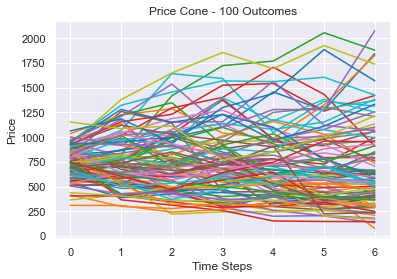

In [33]:
# multiply spot price by each return value in the list of arrays
prices = np.cumprod(1 + returns, 1) * spot
sns.set_palette("tab10")
# plot the price cone for the first 100 outcomes
for i in prices[:100, :]:
    plt.plot(i)
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Price Cone - 100 Outcomes')
plt.show()

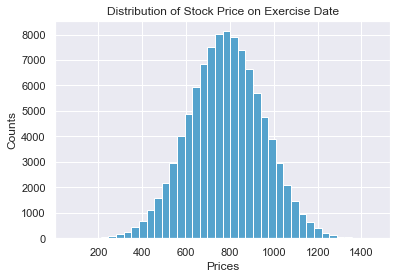

In [34]:
# Visualize the distribution of final prices
sns.set_palette("icefire")
plt.hist(prices[:, 0], bins = 40)
plt.title('Distribution of Stock Price on Exercise Date')
plt.grid(True)
plt.xlabel('Prices')
plt.ylabel('Counts')
plt.show()

Calculate call price as <br>
$$\frac{\Sigma\ intrinsic\ value \times I_{(intrinsic\ value > 0)}}{number\ of\ runs}$$

In [35]:
# calculate the call price!
intrinsicVal = prices[:, 0] - strike
indicator = intrinsicVal > 0
call = np.mean(intrinsicVal * indicator)
call

580.9388583250915

In [36]:
# compare with our accuracy metric - not bad!
calls.loc[0]['Ask']

582.85

## Implementation<a name="7"></a>

In [37]:
# Condense the above into a single for-loop and iterate over each option in our dataset
predictions = []
for i in range(0, len(calls)):
    strike = calls.loc[i]['Strike']
    iv = calls.loc[i]['Implied Volatility']
    returns = np.random.randn(paths, days) * iv / sqrt(tradingDays)
    prices = np.cumprod(1 + returns, 1) * spot
    intrinsicVal = prices[:, -1] - strike
    indicator = intrinsicVal > 0
    call = np.mean(intrinsicVal * indicator)
    predictions.append(call)

In [38]:
# Append predictions column
calls = calls.assign(Monte_Carlo = predictions)
calls.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Black_Scholes,BS_Dif_Pct,abs_BS_Dif_Pct,Monte_Carlo
0,TSLA210226C00200000,2021-02-17 9:55AM EST,200.0,581.90,579.85,582.85,-3.60,-0.61%,20,1,3.4531,586.490399,0.620709,0.620709,583.657720
1,TSLA210226C00250000,2021-02-19 12:51PM EST,250.0,530.60,529.85,532.85,3.00,0.57%,3,9,2.9063,537.761175,0.913263,0.913263,534.784621
2,TSLA210226C00350000,2021-02-17 1:23PM EST,350.0,433.92,429.90,432.85,0.00,-,3,14,2.1523,440.336386,1.700151,1.700151,432.646124
3,TSLA210226C00360000,2021-02-10 2:36PM EST,360.0,453.00,419.90,422.95,0.00,-,5,7,2.1836,430.664295,1.791255,1.791255,423.351350
4,TSLA210226C00370000,2021-02-12 9:35AM EST,370.0,417.80,409.90,412.90,-7.25,-1.71%,2,14,2.0664,420.880462,1.896135,1.896135,412.193986


In [39]:
# Benchmark against ask price
MC_Dif = calls['Monte_Carlo'] - calls['Ask']
MC_Dif.describe()

count    189.000000
mean       1.985867
std        1.914099
min       -1.636055
25%        0.460854
50%        1.136719
75%        3.400452
max        6.165323
dtype: float64

In [40]:
# Compare with the Black Scholes model's results:
BS_Dif.describe()

count    189.000000
mean       5.610001
std        5.746383
min        0.044737
25%        0.206122
50%        2.804571
75%       11.173063
max       15.712723
dtype: float64

Big improvement from the last attempt! The mean and standard deviation both reduced significantly.

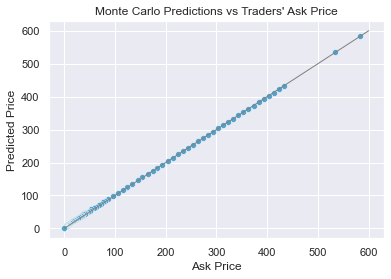

In [41]:
sns.scatterplot(data = calls, x = "Ask", y = "Monte_Carlo")
plt.plot([0, 600], [0, 600], color = 'grey', linewidth = 1)
plt.xlabel("Ask Price")
plt.ylabel("Predicted Price")
plt.title("Monte Carlo Predictions vs Traders' Ask Price")
plt.show()

The data points fit y=x more closely as well.

In [42]:
# Let's examine the percentage difference
calls['MC_Dif_Pct'] = MC_Dif / calls['Monte_Carlo'] * 100
calls.MC_Dif_Pct.describe()

count    189.000000
mean      48.392720
std       33.930914
min       -0.440494
25%        9.699343
50%       61.089573
75%       79.531952
max       91.473631
Name: MC_Dif_Pct, dtype: float64

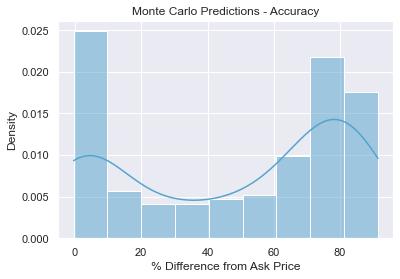

In [43]:
sns.histplot(calls['MC_Dif_Pct'], stat = "density", kde = True)
plt.xlabel("% Difference from Ask Price")
plt.title("Monte Carlo Predictions - Accuracy")
plt.show()

Looking at the % difference, the Monte Carlo method gave slightly better results. A higher percentage of the predictions are closer to the ask price - <br> at least 10% more of the predictions now fall in the 0-10% bin. <br>
However, the density over the 50-70% interval is still higher than desired. Could it be a superposition of 2 curves/peaks, similar to the BS model? <br>Let's take a closer look at what's going on.

## Further Analysis<a name="8"></a>

In [44]:
# Examine options with lowest strike price
calls = calls.assign(abs_MC_Dif_Pct = abs(calls['MC_Dif_Pct']))
MC = calls.sort_values(by = 'abs_MC_Dif_Pct').drop(['Contract Name', 'Last Trade Date', 'Black_Scholes', 'BS_Dif_Pct', 'abs_BS_Dif_Pct'], 1)
MC.head(20).describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,Implied Volatility,Monte_Carlo,MC_Dif_Pct,abs_MC_Dif_Pct
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,443.500000,344.012500,336.492500,339.610000,-3.037500,12.650000,18.050000,1.749160,339.819576,0.075701,0.140030
std,93.317511,94.847243,93.199717,93.123388,6.319567,14.372031,23.038812,0.526414,93.054386,0.148087,0.085567
min,200.000000,182.190000,180.500000,183.300000,-14.940000,1.000000,1.000000,0.991700,183.885980,-0.179319,0.004028
25%,387.500000,302.777500,287.512500,290.737500,-7.190000,3.000000,7.000000,1.499275,291.114971,-0.048570,0.086017
50%,445.000000,340.655000,334.950000,338.075000,0.000000,6.500000,12.000000,1.709950,338.251233,0.102314,0.132128
75%,492.500000,403.712500,392.400000,395.400000,0.000000,17.000000,14.750000,1.944800,395.446222,0.146958,0.167424
max,600.000000,581.900000,579.850000,582.850000,10.150000,53.000000,89.000000,3.453100,583.657720,0.318665,0.318665


In [45]:
# Examine options with highest 20 strike price
MC.tail(20).describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,Implied Volatility,Monte_Carlo,MC_Dif_Pct,abs_MC_Dif_Pct
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000
mean,1476.000000,0.033000,0.018500,0.038000,-0.012500,121.350000,562.70000,1.489465,0.333720,88.806190,88.806190
std,142.048917,0.013416,0.011821,0.016092,0.020995,273.530769,1057.78687,0.174430,0.109417,1.875491,1.875491
min,1200.000000,0.020000,0.010000,0.020000,-0.060000,3.000000,29.00000,1.128900,0.179294,85.424488,85.424488
25%,1387.500000,0.020000,0.010000,0.030000,-0.022500,7.750000,139.75000,1.386700,0.264255,87.247941,87.247941
50%,1485.000000,0.030000,0.015000,0.030000,0.000000,14.000000,207.00000,1.507800,0.330015,88.939526,88.939526
75%,1581.250000,0.040000,0.020000,0.050000,0.000000,70.000000,458.75000,1.619175,0.374379,90.336087,90.336087
max,1700.000000,0.070000,0.050000,0.070000,0.020000,1146.000000,4751.00000,1.734400,0.550004,91.473631,91.473631


Again, the more expensive calls are priced very closely to the ask prices. The inexpensive calls were overpriced. Let's visualize this.

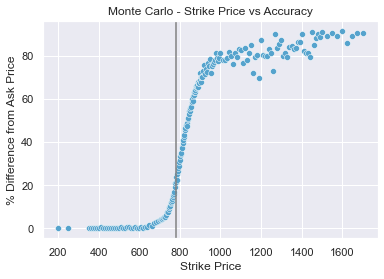

In [46]:
# Regression analysis: how does strike price affect our chosen accuracy metric? (dif between predictions and ask price)
sns.scatterplot(data = calls, x = "Strike", y = "abs_MC_Dif_Pct")
plt.xlabel('Strike Price')
plt.ylabel('% Difference from Ask Price')
plt.title("Monte Carlo - Strike Price vs Accuracy")
plt.axvline(x = spot, color = 'grey') # mark the spot price with a grey line
plt.show()

Predictions for ITM calls are indeed very close to the ask price. Mostly < 10% away! <br>
Compared to the Black Scholes Model, Monte Carlo achieved much greater accuracy for ITM calls. <br>
However, the higher the strike price, the less accurate the results. This means our hypothesis about the superposition of 2 curves may be correct. <br>
Let's confirm this by plotting the accuracy histogram for ITM vs OTM calls.

In [47]:
# Let's look at in-the-money calls only
ITM = calls[calls['Strike'] < spot]
ITM.MC_Dif_Pct.describe()

count    61.000000
mean      4.638942
std       6.210757
min      -0.440494
25%       0.142752
50%       0.711437
75%       7.731688
max      21.559084
Name: MC_Dif_Pct, dtype: float64

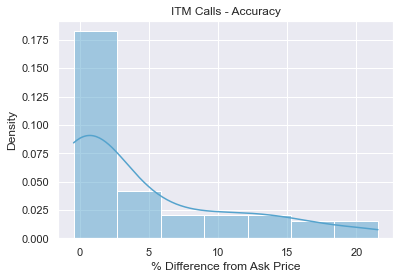

In [48]:
sns.histplot(ITM['MC_Dif_Pct'], stat = "density", kde = True)
plt.xlabel("% Difference from Ask Price")
plt.title("ITM Calls - Accuracy")
plt.show()

In [49]:
# Look at out-of-the-money calls
OTM = calls[calls['Strike'] > spot]
OTM.MC_Dif_Pct.describe()

count    128.000000
mean      69.244130
std       18.120616
min       22.480165
25%       59.779079
50%       76.243079
75%       81.829180
max       91.473631
Name: MC_Dif_Pct, dtype: float64

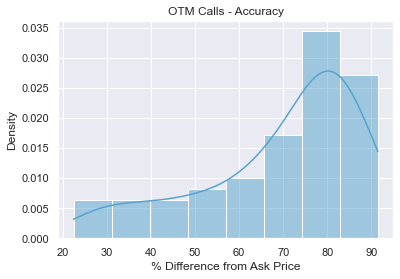

In [50]:
sns.histplot(OTM['MC_Dif_Pct'], stat = "density", kde = True)
plt.xlabel("% Difference from Ask Price")
plt.title("OTM Calls - Accuracy")
plt.show()

It is clear that combining the above ITM & OTM density histograms yields the two-peaked histogram for overall accuracy. <br>
Peak 1 is formed by ITM predictions, and peak 2 is formed by OTM predictions, similar to the plot of our Black Scholes predictions. <br>

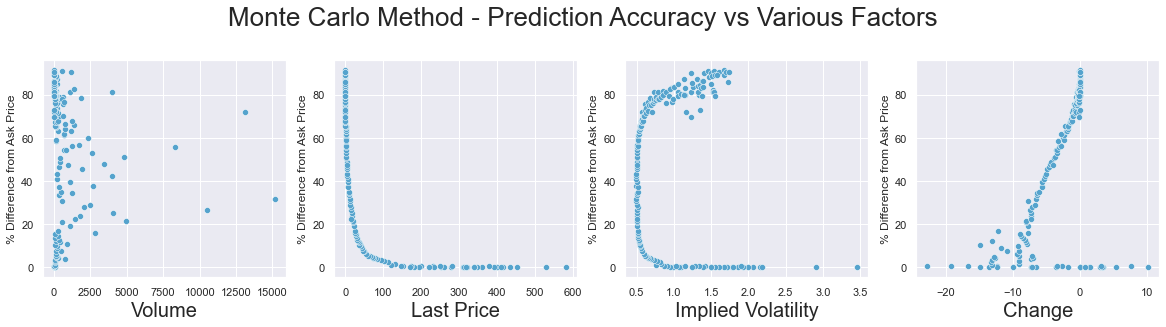

In [51]:
# Examine correlation between accuracy and other factors
subScatter(calls.abs_MC_Dif_Pct, 'Monte Carlo Method')

Similar patterns can be observed (comparing to the BS model):
- accuracy and volume are again not correlated
- higher last transaction prices guarantees higher accuracy in this implementation, and vice versa
- higher iv sometimes leads to higher accuracy
- options with changes of -10% to 0% tend to be less accurate; accuracy decreases as % change $\to$ 0 from -10

Conclusion: <br>

Using ask price as a benchmark, the Monte Carlo method returned accurate predictions for in the money calls. <br>
Looking at ITM calls only, the Black Scholes model did not disappoint either, considering the unrealistic nature of the assumptions. <br>
Neither method achieved high accuracy for OTM calls. The least accurate were those with a % change of -10% to 0%.